In [11]:
import os
import train

path = os.path.join("input", "dataset", "*_NEW.png")
train.train(num_classes=4, num_layers=2, epochs=20, path=path)


Old height and width: 2547 : 3396
New height and width: 2548 : 3400








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
/opt/anaconda3/envs/ComputerVision/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/envs/ComputerVision/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [1]:
import utils

In [4]:
utils.visualize_segmentation_dataset("input/dataset", 4)

Press any key to navigate. 
Found the following classes [0 1 2 3]


In [1]:
import cv2
from utils import compare_masks_red

mask1 = cv2.imread("input/dataset/Py-Cpy-Sh-BR-GL2_NEW.png")
mask2 = cv2.imread("input/dataset/Py-Cpy-Sh-BR-GL27_NEW.png")

result = compare_masks(mask1, mask2)

cv2.imshow("mask", cv2.resize(result, (0, 0), fx=0.2, fy=0.2))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
import cv2
from utils import compare_masks_rgb
import numpy as np

mask1 = cv2.imread("input/dataset/Py-Cpy-Sh-BR-GL2_NEW.png")
mask2 = cv2.imread("input/dataset/Py-Cpy-Sh-BR-GL27_NEW.png")

max1 = np.amax(mask1)
max2 = np.amax(mask2)

#result = compare_masks_rgb(np.multiply(mask1, 255 / max1), np.multiply(mask2, 255 / max2))
result = compare_masks_rgb(mask1, mask2)

cv2.imshow("mask", cv2.resize(result, (0, 0), fx=0.2, fy=0.2))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
import cv2
from utils import visualize_segmentation_result
from data_utils.load_data import get_imgs_masks

imgs, masks = get_imgs_masks("/Users/Alexey/Desktop/Geology/input/dataset/*_NEW.png")

print('!')

#visualize_segmentation_result(imgs, masks)


!


In [2]:
print(masks[0].shape)

(2547, 3396, 3)


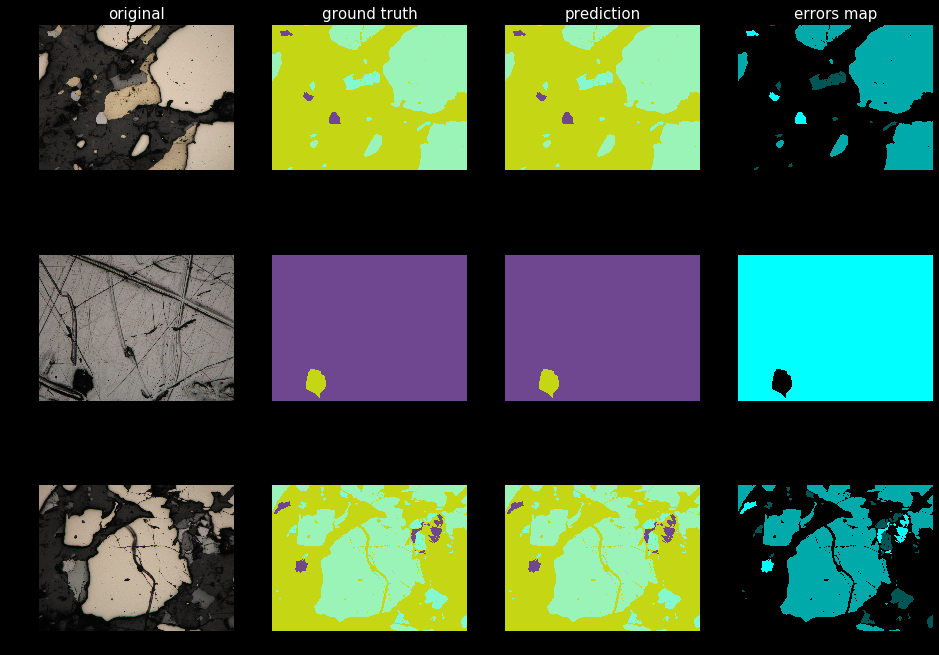

In [2]:
visualize_segmentation_result(imgs, masks, preds=masks, nm_img_to_plot=3)
#visualize_segmentation_result(imgs, masks, nm_img_to_plot=3)

In [1]:
import train

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

ModuleNotFoundError: No module named 'cv2'